In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


NVIDIA GeForce RTX 3070 Ti


In [2]:
class DownSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, dilation=1, kernel_size=15, stride=1, padding=7):
        super(DownSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1)
        )

    def forward(self, ipt):
        return self.main(ipt)

class UpSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=5, stride=1, padding=2):
        super(UpSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

    def forward(self, ipt):
        return self.main(ipt)

class Model(nn.Module):
    def __init__(self, n_layers=12, channels_interval=24):
        super(Model, self).__init__()

        self.n_layers = n_layers
        self.channels_interval = channels_interval
        encoder_in_channels_list = [1] + [i * self.channels_interval for i in range(1, self.n_layers)]
        encoder_out_channels_list = [i * self.channels_interval for i in range(1, self.n_layers + 1)]

        #          1    => 2    => 3    => 4    => 5    => 6   => 7   => 8   => 9  => 10 => 11 =>12
        # 16384 => 8192 => 4096 => 2048 => 1024 => 512 => 256 => 128 => 64 => 32 => 16 =>  8 => 4
        self.encoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.encoder.append(
                DownSamplingLayer(
                    channel_in=encoder_in_channels_list[i],
                    channel_out=encoder_out_channels_list[i]
                )
            )

        self.middle = nn.Sequential(
            nn.Conv1d(self.n_layers * self.channels_interval, self.n_layers * self.channels_interval, 15, stride=1,
                      padding=7),
            nn.BatchNorm1d(self.n_layers * self.channels_interval),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        decoder_in_channels_list = [(2 * i + 1) * self.channels_interval for i in range(1, self.n_layers)] + [
            2 * self.n_layers * self.channels_interval]
        decoder_in_channels_list = decoder_in_channels_list[::-1]
        decoder_out_channels_list = encoder_out_channels_list[::-1]
        self.decoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.decoder.append(
                UpSamplingLayer(
                    channel_in=decoder_in_channels_list[i],
                    channel_out=decoder_out_channels_list[i]
                )
            )

        self.out = nn.Sequential(
            nn.Conv1d(1 + self.channels_interval, 1, kernel_size=1, stride=1),
            nn.Tanh()
        )

    def forward(self, input):
        tmp = []
        o = input

        # Up Sampling
        for i in range(self.n_layers):
            o = self.encoder[i](o)
            tmp.append(o)
            # [batch_size, T // 2, channels]
            o = o[:, :, ::2]

        o = self.middle(o)

        # Down Sampling
        for i in range(self.n_layers):
            # [batch_size, T * 2, channels]
            o = F.interpolate(o, scale_factor=2, mode="linear", align_corners=True)
            # Skip Connection
            o = torch.cat([o, tmp[self.n_layers - i - 1]], dim=1)
            o = self.decoder[i](o)

        o = torch.cat([o, input], dim=1)
        o = self.out(o)
        return o

In [3]:
import torch.onnx

In [26]:
model = Model()
print(model)


Model(
  (encoder): ModuleList(
    (0): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(1, 24, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(24, 48, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (2): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(48, 72, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (3): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(72, 96, kernel_size=(15,), stride=(1,), padding=(7,))
       

In [63]:
# 2. model의 파라미터를 OrderedDict 형태로 저장합니다.
params = model.state_dict()
# 3. 동적 그래프 형태의 pytorch model을 위하여 data를 model로 흘려주기 위한 더미 데이터 입니다.
dummy_data = torch.empty((1,1,16384,))
# 4. onnx 파일을 export 해줍니다. 함수에는 차례대로 model, data, 저장할 파일명 순서대로 들어가면 됩니다.
torch.onnx.export(model, dummy_data, "./model/output.onnx", verbose=True,opset_version=11, input_names="x", output_names="y")


graph(%x : Float(1:16384, 1:16384, 16384:1, requires_grad=0, device=cpu),
      %out.0.weight : Float(1:25, 25:1, 1:1, requires_grad=1, device=cpu),
      %out.0.bias : Float(1:1, requires_grad=1, device=cpu),
      %389 : Float(24:15, 1:15, 15:1, requires_grad=0, device=cpu),
      %390 : Float(24:1, requires_grad=0, device=cpu),
      %392 : Float(48:360, 24:15, 15:1, requires_grad=0, device=cpu),
      %393 : Float(48:1, requires_grad=0, device=cpu),
      %395 : Float(72:720, 48:15, 15:1, requires_grad=0, device=cpu),
      %396 : Float(72:1, requires_grad=0, device=cpu),
      %398 : Float(96:1080, 72:15, 15:1, requires_grad=0, device=cpu),
      %399 : Float(96:1, requires_grad=0, device=cpu),
      %401 : Float(120:1440, 96:15, 15:1, requires_grad=0, device=cpu),
      %402 : Float(120:1, requires_grad=0, device=cpu),
      %404 : Float(144:1800, 120:15, 15:1, requires_grad=0, device=cpu),
      %405 : Float(144:1, requires_grad=0, device=cpu),
      %407 : Float(168:2160, 144:1

In [52]:
import librosa

In [44]:
mixture, _ = librosa.load("./sample/p232_104__mixed_conditioned0_2dB.wav", sr=None)

In [47]:
np.shape(mixture)

(55200,)

In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import DataLoader

In [39]:
dataloader = DataLoader(dataset=initialize_config(config["dataset"]), batch_size=1, num_workers=0)

(55200,)

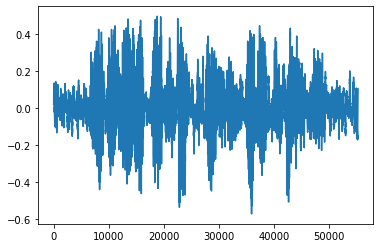

In [49]:
plt.plot(mixture)